In [111]:
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

import itertools

import statsmodels.api as sm


In [112]:
engine = create_engine('sqlite:///cubic_perovskites.db')
with engine.connect() as conn, conn.begin():
    keyvalues = pd.read_sql_table('number_key_values', conn)
    textvalues = pd.read_sql_table('text_key_values', conn)
    keys = pd.read_sql_table('keys', conn)
    systems = pd.read_sql_table('systems',conn)

### The cell below return a dataframe for each variable

In [113]:
CB_ind = keyvalues[(keyvalues.key=='CB_ind')]
gllbsc_ind_gap = keyvalues[(keyvalues.key=='gllbsc_ind_gap')]
CB_dir = keyvalues[(keyvalues.key=='CB_dir')]
VB_dir = keyvalues[(keyvalues.key=='VB_dir')]
VB_ind = keyvalues[(keyvalues.key=='VB_ind')]
gllbsc_dir_gap = keyvalues[(keyvalues.key=='gllbsc_dir_gap')]
heat_of_formation = keyvalues[(keyvalues.key=='heat_of_formation_all')]
standard_energy = keyvalues[(keyvalues.key=='standard_energy')]


### The cells below build a dataframe for all the values. 
id is the ID of the perovskite

In [114]:
valuelist=[CB_dir,VB_dir,VB_ind,gllbsc_dir_gap,gllbsc_ind_gap,heat_of_formation,standard_energy]
values = CB_ind
for x in valuelist:
    values = pd.merge(values,x,how='outer',on='id')

In [115]:
values.set_index('id',inplace=True)

In [116]:
values.columns=['key','CB_ind','key','CB_dir','key','VB_dir','key','VB_ind','key','gllbsc_dir_gap','key','gllbsc_ind_gap','key','heat_of_formation','key','standard_energy']

In [117]:
values=values.drop(columns='key')

### The cells below build dataframe for A_ion, B_ion and Anion, each dataframe contains the ion's electronegativity and first ionization energy

anion's electronegativity and first ionization energy are calculated from average value of each atom

In [118]:
A_ion = textvalues[(textvalues.key=='A_ion')]
B_ion = textvalues[(textvalues.key=='B_ion')]
anion = textvalues[(textvalues.key=='anion')]

electroneg = pd.read_csv('electronegativity.csv')
electroneg.columns = ['value', 'electronegativity']

A_electroneg=pd.merge(A_ion,electroneg,how='left',on='value')
B_electroneg=pd.merge(B_ion,electroneg,how='left',on='value')

ionization=pd.read_excel('ionization energy.xlsx')
A_values=pd.merge(A_electroneg,ionization,how='left',on='value')
B_values=pd.merge(B_electroneg,ionization,how='left',on='value')

Rmax = pd.read_excel('Rmax.xlsx')
A_values = pd.merge(A_values,Rmax,how='left',on='value')
B_values = pd.merge(B_values,Rmax,how='left',on='value')

affinity = pd.read_excel('electron affinities.xlsx')
A_values = pd.merge(A_values,affinity,how='left',on='value')
B_values = pd.merge(B_values,affinity,how='left',on='value')

In [119]:
A_values.columns=['key','A_ion','id','A_X','A_IE','A_s_R','A_p_R','A_d_R','A_aff']
B_values.columns=['key','B_ion','id','B_X','B_IE','B_s_R','B_p_R','B_d_R','B_aff']


In [120]:
cation_values=pd.merge(A_values,B_values,how='outer',on='id')


In [121]:
cation_values.head()

,key_x,A_ion,id,A_X,A_IE,A_s_R,A_p_R,A_d_R,A_aff,key_y,B_ion,B_X,B_IE,B_s_R,B_p_R,B_d_R,B_aff
0,A_ion,Ti,1,1.54,6.82810,162.2,NaN,52.8,0.084000,B_ion,As,2.18,9.78860,88.5,106.6,25.4,0.804800
1,A_ion,K,2,0.82,4.34066,230.0,NaN,NaN,0.501459,B_ion,Sb,2.05,8.60840,106.5,126.6,44.7,1.047401
2,A_ion,Hg,3,2.00,10.43750,141.7,NaN,60.8,-0.520000,B_ion,Nb,1.60,6.75885,181.9,NaN,78.9,0.917400
3,A_ion,Bi,4,2.02,7.28560,114.4,136.1,54.2,0.942362,B_ion,Sb,2.05,8.60840,106.5,126.6,44.7,1.047401
4,A_ion,Na,5,0.93,5.13908,179.1,NaN,NaN,0.547926,B_ion,Ag,1.93,7.57620,153.2,NaN,54.7,1.304470


In [122]:
anion_electronegativity=[3.04,3.62,3.30666,3.15333,3.44,3.48666,3.17333]
#this is calculated from the average of atom's electronegativity
anion_ionization=[14.53414,14.88631,13.92342,12.53204,13.61806,15.19167,14.22878]
#this is calculated from the average of atom's ionization
anion_data = pd.DataFrame({'value':['N3','O2F','O2N','O2S','O3','OFN','ON2'],'electronegativity':anion_electronegativity,'first ionization energy':anion_ionization})
anion_data

,electronegativity,first ionization energy,value
0,3.04000,14.53414,N3
1,3.62000,14.88631,O2F
2,3.30666,13.92342,O2N
3,3.15333,12.53204,O2S
4,3.44000,13.61806,O3
5,3.48666,15.19167,OFN
6,3.17333,14.22878,ON2


In [123]:
anion_values=pd.merge(anion,anion_data,how='left',on='value')

In [124]:
anion_values.columns=['key','anion','id','anion_X','anion_IE']

In [125]:
perovskite_values=pd.merge(anion_values,cation_values,how='outer',on='id')

In [126]:
perovskite_values.head()

,key,anion,id,anion_X,anion_IE,key_x,A_ion,A_X,A_IE,A_s_R,...,A_d_R,A_aff,key_y,B_ion,B_X,B_IE,B_s_R,B_p_R,B_d_R,B_aff
0,anion,O2N,1,3.30666,13.92342,A_ion,Ti,1.54,6.82810,162.2,...,52.8,0.084000,B_ion,As,2.18,9.78860,88.5,106.6,25.4,0.804800
1,anion,O2N,2,3.30666,13.92342,A_ion,K,0.82,4.34066,230.0,...,NaN,0.501459,B_ion,Sb,2.05,8.60840,106.5,126.6,44.7,1.047401
2,anion,O2N,3,3.30666,13.92342,A_ion,Hg,2.00,10.43750,141.7,...,60.8,-0.520000,B_ion,Nb,1.60,6.75885,181.9,NaN,78.9,0.917400
3,anion,O2N,4,3.30666,13.92342,A_ion,Bi,2.02,7.28560,114.4,...,54.2,0.942362,B_ion,Sb,2.05,8.60840,106.5,126.6,44.7,1.047401
4,anion,O2N,5,3.30666,13.92342,A_ion,Na,0.93,5.13908,179.1,...,NaN,0.547926,B_ion,Ag,1.93,7.57620,153.2,NaN,54.7,1.304470


### The cell below get two dataframe: mass and volume
id is the ID of perovskite

In [127]:
volume = pd.DataFrame({'id': systems.id, 'volume':systems.volume})
mass = pd.DataFrame({'id': systems.id, 'mass':systems.mass})

In [128]:
volume.head()

,id,volume
0,1,60.301946
1,2,69.072728
2,3,70.420772
3,4,71.053021
4,5,73.668620


In [129]:
perovskite=pd.merge(perovskite_values,volume,how='left',on='id')
perovskite=pd.merge(perovskite,mass,how='left',on='id')

In [130]:
perovskite=perovskite.drop(columns=['key','key_x','key_y'])

In [131]:
perovskite.set_index('id',inplace=True)

In [132]:
perovskite['density']=perovskite['mass']/perovskite['volume']

In [133]:
# remove all the NaN 
perovskite = perovskite.fillna(0.)

In [134]:
perovskite['A_R']=perovskite['A_s_R']+perovskite['A_p_R']+perovskite['A_d_R']
perovskite['B_R']=perovskite['B_s_R']+perovskite['B_p_R']+perovskite['B_d_R']

In [135]:
perovskite.head()

,anion,anion_X,anion_IE,A_ion,A_X,A_IE,A_s_R,A_p_R,A_d_R,A_aff,...,B_IE,B_s_R,B_p_R,B_d_R,B_aff,volume,mass,density,A_R,B_R
id,,,,,,,,,,,,,,,,,,,,,
1,O2N,3.30666,13.92342,Ti,1.54,6.82810,162.2,0.0,52.8,0.084000,...,9.78860,88.5,106.6,25.4,0.804800,60.301946,168.80710,2.799364,215.0,220.5
2,O2N,3.30666,13.92342,K,0.82,4.34066,230.0,0.0,0.0,0.501459,...,8.60840,106.5,126.6,44.7,1.047401,69.072728,206.86080,2.994826,230.0,277.8
3,O2N,3.30666,13.92342,Hg,2.00,10.43750,141.7,0.0,60.8,-0.520000,...,6.75885,181.9,0.0,78.9,0.917400,70.420772,339.50190,4.821048,202.5,260.8
4,O2N,3.30666,13.92342,Bi,2.02,7.28560,114.4,136.1,54.2,0.942362,...,8.60840,106.5,126.6,44.7,1.047401,71.053021,376.74290,5.302278,304.7,277.8
5,O2N,3.30666,13.92342,Na,0.93,5.13908,179.1,0.0,0.0,0.547926,...,7.57620,153.2,0.0,54.7,1.304470,73.668620,176.86327,2.400795,179.1,207.9


In [136]:
perovskite.shape

(18928, 22)

In [137]:
# remove all the NaN line
values = values[(values.CB_ind > 0.0)]

In [138]:
values.head()

,CB_ind,CB_dir,VB_dir,VB_ind,gllbsc_dir_gap,gllbsc_ind_gap,heat_of_formation,standard_energy
id,,,,,,,,
1,5.962712,5.962712,5.962712,5.962712,0.0,0.0,1.20,-2.771908
2,5.456778,5.456778,5.456778,5.456778,0.0,0.0,0.60,-2.015260
3,5.603095,5.333095,6.913095,6.643095,1.6,1.0,0.54,-3.706880
4,6.066547,6.066547,6.066547,6.066547,0.0,0.0,0.88,-0.498542
5,5.539498,5.539498,5.539498,5.539498,0.0,0.0,1.78,3.552433


only 735 lines positive bandgap data

In [139]:
data_total=pd.merge(perovskite,values,how='outer',left_index=True,right_index=True)

the dataframe 'data_total' is a collection of all the data

In [140]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

%matplotlib inline

In [141]:
seed = 21899

In [142]:
X = data_total[['anion_X', 'anion_IE', 'A_X', 'A_IE', 'A_s_R',
       'A_p_R', 'A_d_R', 'A_aff' , 'B_X', 'B_IE', 'B_s_R', 'B_p_R',
       'B_d_R', 'B_aff', 'volume', 'mass', 'density', 'A_R', 'B_R', 'CB_ind',
       'CB_dir', 'VB_dir', 'VB_ind', 'gllbsc_dir_gap', 'gllbsc_ind_gap',
       'heat_of_formation', 'standard_energy']].values
Y = data_total[['gllbsc_dir_gap']].values

In [143]:
X_train_pn,X_test_pn,y_train,y_test = train_test_split(X, Y, test_size=0.20,random_state=seed)

In [144]:
X_train_scaler = StandardScaler().fit(X_train_pn)
X_train = X_train_scaler.transform(X_train_pn)

In [145]:
def model():
    model = Sequential()
    model.add(Dense(27, input_dim=27, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

In [146]:
np.random.seed(seed)
estimator = KerasRegressor(build_fn= model,
        epochs=150, batch_size=10000, verbose=0)
history = estimator.fit(X_train, y_train, validation_split=0.33, epochs=150, 
        batch_size=5000, verbose=0)

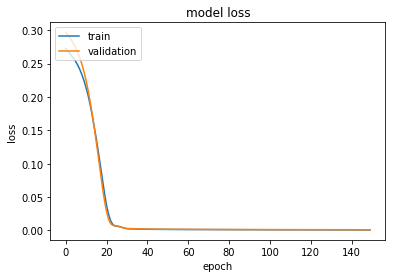

In [147]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [152]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [155]:
print("final accuracy for train is %.2f and for validation is %.2f" % 
      (history.history['acc'][-1], history.history['val_acc'][-1]))

final accuracy for train is 0.96 and for validation is 0.97


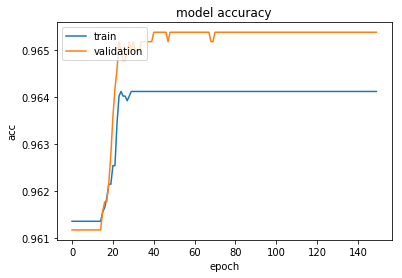

In [156]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [162]:
test_loss = estimator.model.evaluate(X_test, y_test)
type(test_loss)
print("test set accuracy is %.2f" % test_loss[1])

3786/3786 [==============================] - 0s 114us/step
test set accuracy is 0.96
